In [10]:
import subprocess, sys

# Run backend from Jupyter
proc = subprocess.Popen([
    sys.executable, 
    "-m", "uvicorn", 
    "Backend.main:app",   # folder.file:object
    "--reload", 
    "--port", "8000"
])

print("🚀 Backend running at http://127.0.0.1:8000  (PID:", proc.pid, ")")

# Later you can stop with:
# proc.terminate()
# proc.kill()


🚀 Backend running at http://127.0.0.1:8000  (PID: 26680 )


In [11]:
import requests

# Test without detection
url = "http://127.0.0.1:8000/proxy/Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm/0/0/0.jpg"
r = requests.get(url)
print("Status:", r.status_code)
print("Content type:", r.headers["content-type"])

# Test with detection
url_detect = url + "?detect=true"
r2 = requests.get(url_detect)
print("Status:", r2.status_code)
print("JSON:", r2.json())
import requests

# Test without detection
url = "http://127.0.0.1:8000/proxy/Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm/0/0/0.jpg"
r = requests.get(url)
print("Status:", r.status_code)
print("Content type:", r.headers["content-type"])

# Test with detection
url_detect = url + "?detect=true"
r2 = requests.get(url_detect)
print("Status:", r2.status_code)
print("JSON:", r2.json())


Status: 200
Content type: image/jpeg
Status: 200
JSON: {'features': []}
Status: 200
Content type: image/jpeg
Status: 200
JSON: {'features': []}


In [39]:
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import requests, io
import torch

In [41]:
proxy = "http://127.0.0.1:8000/proxy"
level = 0  # small, for testing
tile_url = f"{proxy}/Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm/{level}/0/0.jpg"

r = requests.get(tile_url)
full_img = Image.open(io.BytesIO(r.content)).convert("RGB")
full_width, full_height = full_img.size
print(f"Loaded Moon base map: {full_width} x {full_height}")

Loaded Moon base map: 256 x 256


Using cache found in C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-9-24 Python-3.13.5 torch-2.8.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\Admin/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 256x256 (no detections)
Speed: 2449.5ms pre-process, 405.3ms inference, 1.0ms NMS per image at shape (1, 3, 640, 640)


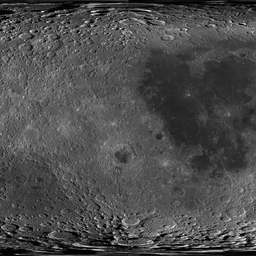

In [42]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
results = model(tile_url)
results.print()
results.show()

# Save YOLO detections
df_yolo = results.pandas().xyxy[0]
df_yolo.to_csv("detections_yolo.csv", index=False)


In [45]:
shapefile_path = "MoonData/MOON_nomenclature_center_pts.shp"
gdf = gpd.read_file(shapefile_path)
print(gdf.head())
print(gdf.columns)


             name      clean_name           approvaldt  \
0   Sinus Lunicus   Sinus Lunicus  1970/01/01 00:00:00   
1    Marco Polo P    Marco Polo P  2006/01/01 00:00:00   
2  Vallis Krishna  Vallis Krishna  1976/01/01 00:00:00   
3   Rima Sung-Mei   Rima Sung Mei  1985/01/01 00:00:00   
4  Rima Siegfried  Rima Siegfried  1976/01/01 00:00:00   

                                        origin    diameter  ...  continent  \
0  "Lunik Bay"-landing area of Luna (Lunik) 2.  119.175380  ...     Europe   
1                Italian explorer (1254-1324).   28.062080  ...     Europe   
2         Indian male name, part of Aratus CA.    2.896135  ...       Asia   
3      Chinese female name; part of Aratus CA.    3.875760  ...       Asia   
4                            German male name.   13.958291  ...     Europe   

          quad_name quad_code  \
0           Cassini    LAC-25   
1  Montes Apenninus    LAC-41   
2  Mare Serenitatis    LAC-42   
3  Mare Serenitatis    LAC-42   
4           Hilbe

In [46]:
def lonlat_to_pixel(lon, lat, width, height):
    x = (lon + 180.0) / 360.0 * width
    y = (90.0 - lat) / 180.0 * height
    return int(x), int(y)

In [50]:
# Ensure the geometry is Point
gdf = gdf[gdf.geometry.type == "Point"]

# Extract lon/lat from geometry
gdf["lon"] = gdf.geometry.x
gdf["lat"] = gdf.geometry.y

# Optional: check
print(gdf[["lon", "lat", "origin"]].head())


        lon      lat                                       origin
0  358.1489  32.3641  "Lunik Bay"-landing area of Luna (Lunik) 2.
1  359.6815  16.9673                Italian explorer (1254-1324).
2   11.2632  24.5023         Indian male name, part of Aratus CA.
3   11.2842  24.5878      Chinese female name; part of Aratus CA.
4  103.0067 -25.8220                            German male name.


In [51]:
draw = ImageDraw.Draw(full_img)

for idx, row in gdf.iterrows():
    lon = row["lon"]
    lat = row["lat"]
    name = row["origin"]  # or use 'name' if you have that column

    px, py = lonlat_to_pixel(lon, lat, full_width, full_height)

    r = 3
    draw.ellipse((px-r, py-r, px+r, py+r), outline="red", fill="red")
    draw.text((px+5, py), name, fill="yellow")


In [52]:
full_img.show()
full_img.save("moon_labeled.jpg")

new 


In [53]:
import geopandas as gpd
from PIL import Image, ImageDraw
import requests, io
import pandas as pd
import torch
from types import SimpleNamespace

In [55]:
proxy = "http://127.0.0.1:8000/proxy"
level = 0  # small, for testing
tile_url = f"{proxy}/Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm/{level}/0/0.jpg"

r = requests.get(tile_url)
full_img = Image.open(io.BytesIO(r.content)).convert("RGB")
full_width, full_height = full_img.size
print(f"Moon map size: {full_width} x {full_height}")


Moon map size: 256 x 256


In [57]:
shapefile_path = "MoonData/MOON_nomenclature_center_pts.shp"
gdf = gpd.read_file(shapefile_path)

# Check column names
print(gdf.columns)

Index(['name', 'clean_name', 'approvaldt', 'origin', 'diameter', 'center_lon',
       'center_lat', 'type', 'code', 'approval', 'min_lon', 'max_lon',
       'min_lat', 'max_lat', 'ethnicity', 'continent', 'quad_name',
       'quad_code', 'link', 'geometry'],
      dtype='object')


In [58]:
def lonlat_to_pixel(lon, lat, width, height):
    x = (lon + 180.0) / 360.0 * width
    y = (90.0 - lat) / 180.0 * height
    return int(x), int(y)

In [60]:
detections = []

# Ensure geometry is Point
gdf = gdf[gdf.geometry.type == "Point"]

for idx, row in gdf.iterrows():
    # Extract lon/lat from geometry
    lon = row.geometry.x
    lat = row.geometry.y
    
    # Use a name column if available, otherwise fallback
    if "origin" in gdf.columns:
        name = row["origin"]
    elif "NAME" in gdf.columns:
        name = row["NAME"]
    else:
        name = "?"

    # Convert lon/lat to pixel coordinates on your image
    px, py = lonlat_to_pixel(lon, lat, full_width, full_height)

    # Create a small bounding box around the point
    r = 4  # radius in pixels
    xmin, ymin = px - r, py - r
    xmax, ymax = px + r, py + r
    confidence = 1.0  # placeholder confidence

    # Append detection to list
    detections.append([xmin, ymin, xmax, ymax, confidence, name])


In [61]:
df = pd.DataFrame(detections, columns=["xmin", "ymin", "xmax", "ymax", "confidence", "class"])
print(df.head())
df.to_csv("moon_yolo_detections.csv", index=False)

   xmin  ymin  xmax  ymax  confidence  \
0   378    77   386    85         1.0   
1   379    99   387   107         1.0   
2   132    89   140    97         1.0   
3   132    89   140    97         1.0   
4   197   160   205   168         1.0   

                                         class  
0  "Lunik Bay"-landing area of Luna (Lunik) 2.  
1                Italian explorer (1254-1324).  
2         Indian male name, part of Aratus CA.  
3      Chinese female name; part of Aratus CA.  
4                            German male name.  


In [65]:
draw = ImageDraw.Draw(full_img)

for _, row in df.iterrows():
    x1, y1, x2, y2 = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
    cls = row["class"]

    # Draw box
    draw.rectangle([x1, y1, x2, y2], outline="red", width=1)
    # Draw label
    draw.text((x1, y1-10), cls, fill="yellow")

full_img.show()
full_img.save("moon_yolo_labeled.jpg")

new again


In [ ]:
import requests, io, os
from PIL import Image, ImageDraw, ImageFont
import geopandas as gpd
import math

# -----------------------------
# 1. SETTINGS
# -----------------------------
# NASA Trek Moon tile server (through your local proxy if needed)
proxy = "http://127.0.0.1:8000/proxy"
layer = "Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm"

# Choose zoom level (2 = low res, 4 = decent global, 5+ = very high res but huge)
zoom = 2

# Shapefile path (your downloaded files)
shapefile_path = "MoonData/MOON_nomenclature_center_pts.shp"

# Output image
output_file = "moon_yolo_labeled.jpg"

# -----------------------------
# 2. FETCH + STITCH TILES
# -----------------------------
tile_size = 256  # Trek uses 256px tiles
num_tiles = 2 ** zoom  # number of tiles across

print(f"Fetching {num_tiles} × {num_tiles} tiles at zoom {zoom}...")

full_img = Image.new("RGB", (num_tiles * tile_size, num_tiles * tile_size))

for x in range(num_tiles):
    for y in range(num_tiles):
        url = f"{proxy}/{layer}/{zoom}/{y}/{x}.jpg"
        r = requests.get(url)
        if r.status_code == 200:
            tile = Image.open(io.BytesIO(r.content)).convert("RGB")
            full_img.paste(tile, (x * tile_size, y * tile_size))
        else:
            print(f"⚠️ Missing tile: {url}")

width, height = full_img.size
print(f"✅ Stitched image size: {width} × {height}")

# -----------------------------
# 3. LOAD SHAPEFILE
# -----------------------------
gdf = gpd.read_file(shapefile_path)
print("Columns:", gdf.columns)
print("Total features:", len(gdf))

# Keep only points
gdf = gdf[gdf.geometry.type == "Point"]

# -----------------------------
# 4. CONVERT LON/LAT → PIXEL
# -----------------------------
def lonlat_to_pixel(lon, lat, width, height):
    """
    Map lon (-180→180), lat (90→-90) to pixel (x, y).
    Image is global equirectangular projection.
    """
    x = (lon + 180.0) / 360.0 * width
    y = (90.0 - lat) / 180.0 * height
    return int(x), int(y)

# -----------------------------
# 5. DRAW LABELS
# -----------------------------
draw = ImageDraw.Draw(full_img)
font = ImageFont.load_default()

for idx, row in gdf.iterrows():
    name = row["name"]
    ftype = row.get("type", "")
    lon, lat = row["center_lon"], row["center_lat"]

    px, py = lonlat_to_pixel(lon, lat, width, height)

    # Small box
    r = 3
    draw.rectangle([px-r, py-r, px+r, py+r], outline="red", width=1)

    # Label
    label = f"{name} ({ftype})" if ftype else name
    draw.text((px+5, py), label, fill="yellow", font=font)


Fetching 4 × 4 tiles at zoom 2...
✅ Stitched image size: 1024 × 1024
Columns: Index(['name', 'clean_name', 'approvaldt', 'origin', 'diameter', 'center_lon',
       'center_lat', 'type', 'code', 'approval', 'min_lon', 'max_lon',
       'min_lat', 'max_lat', 'ethnicity', 'continent', 'quad_name',
       'quad_code', 'link', 'geometry'],
      dtype='object')
Total features: 9084
✅ Saved labeled Moon map → moon_yolo_labeled.jpg


Index(['name', 'clean_name', 'approvaldt', 'origin', 'diameter', 'center_lon',
       'center_lat', 'type', 'code', 'approval', 'min_lon', 'max_lon',
       'min_lat', 'max_lat', 'ethnicity', 'continent', 'quad_name',
       'quad_code', 'link', 'geometry'],
      dtype='object')
             name      clean_name           approvaldt  \
0   Sinus Lunicus   Sinus Lunicus  1970/01/01 00:00:00   
1    Marco Polo P    Marco Polo P  2006/01/01 00:00:00   
2  Vallis Krishna  Vallis Krishna  1976/01/01 00:00:00   
3   Rima Sung-Mei   Rima Sung Mei  1985/01/01 00:00:00   
4  Rima Siegfried  Rima Siegfried  1976/01/01 00:00:00   

                                        origin    diameter  ...  continent  \
0  "Lunik Bay"-landing area of Luna (Lunik) 2.  119.175380  ...     Europe   
1                Italian explorer (1254-1324).   28.062080  ...     Europe   
2         Indian male name, part of Aratus CA.    2.896135  ...       Asia   
3      Chinese female name; part of Aratus CA.    3.875760

all cretors


In [70]:
import requests, io
from PIL import Image, ImageDraw, ImageFont
import geopandas as gpd

# -----------------------------
# 1. SETTINGS
# -----------------------------
proxy = "http://127.0.0.1:8000/proxy"
layer = "Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm"

zoom = 2  # try 2 first; increase to 3 or 4 for more detail (but larger images)

shapefile_path = "MoonData/MOON_nomenclature_center_pts.shp"
output_file = "moon_yolo_labeled.jpg"

# -----------------------------
# 2. FETCH + STITCH TILES
# -----------------------------
tile_size = 256
num_tiles = 2 ** zoom  # number of tiles across for equirectangular map

print(f"Fetching {num_tiles} × {num_tiles} tiles at zoom {zoom}...")

full_img = Image.new("RGB", (num_tiles * tile_size, num_tiles * tile_size))

for x in range(num_tiles):
    for y in range(num_tiles):
        url = f"{proxy}/{layer}/{zoom}/{y}/{x}.jpg"
        r = requests.get(url)
        if r.status_code == 200:
            tile = Image.open(io.BytesIO(r.content)).convert("RGB")
            full_img.paste(tile, (x * tile_size, y * tile_size))
        else:
            print(f"⚠️ Missing tile: {url}")

width, height = full_img.size
print(f"✅ Stitched image size: {width} × {height}")

# -----------------------------
# 3. LOAD SHAPEFILE
# -----------------------------
gdf = gpd.read_file(shapefile_path)
print("Columns:", gdf.columns)
print("Total features:", len(gdf))

# -----------------------------
# 4. CONVERT LON/LAT → PIXEL
# -----------------------------
def lonlat_to_pixel(lon, lat, width, height):
    """
    Map lon (-180→180), lat (90→-90) to pixel (x, y).
    Image is global equirectangular projection.
    """
    x = (lon + 180.0) / 360.0 * width
    y = (90.0 - lat) / 180.0 * height
    return int(x), int(y)

# -----------------------------
# 5. DRAW LABELS
# -----------------------------
draw = ImageDraw.Draw(full_img)
font = ImageFont.load_default()

for idx, row in gdf.iterrows():
    try:
        name = row["name"]
        ftype = row.get("type", "")
        lon, lat = row["center_lon"], row["center_lat"]

        px, py = lonlat_to_pixel(lon, lat, width, height)

        # Draw a small red box
        r = 2
        draw.rectangle([px-r, py-r, px+r, py+r], outline="red", width=1)

        # Label: name + type
        label = f"{name} ({ftype})" if ftype else name
        draw.text((px+5, py), label, fill="yellow", font=font)
    except Exception as e:
        print(f"Skipping row {idx} due to error: {e}")

# -----------------------------
# 6. SAVE OUTPUT
# -----------------------------
full_img.save(output_file)
print(f"✅ Saved labeled Moon map → {output_file}")


Fetching 4 × 4 tiles at zoom 2...
✅ Stitched image size: 1024 × 1024
Columns: Index(['name', 'clean_name', 'approvaldt', 'origin', 'diameter', 'center_lon',
       'center_lat', 'type', 'code', 'approval', 'min_lon', 'max_lon',
       'min_lat', 'max_lat', 'ethnicity', 'continent', 'quad_name',
       'quad_code', 'link', 'geometry'],
      dtype='object')
Total features: 9084
✅ Saved labeled Moon map → moon_yolo_labeled.jpg


Big

In [71]:
import requests, io
from PIL import Image, ImageDraw, ImageFont
import geopandas as gpd

# -----------------------------
# 1. SETTINGS
# -----------------------------
proxy = "http://127.0.0.1:8000/proxy"
layer = "Moon/EQ/LRO_WAC_Mosaic_Global_303ppd_v02/1.0.0/default/default028mm"

zoom = 3  # test with 2 or 3 first, 4 for detailed output

shapefile_path = "MoonData/MOON_nomenclature_center_pts.shp"
output_file = "moon_yolo_labeled_filtered.jpg"

min_diameter = 50   # km, only label features bigger than this
max_labels = 500    # optional: cap total number of labels to avoid clutter

# -----------------------------
# 2. FETCH + STITCH TILES
# -----------------------------
tile_size = 256
num_tiles = 2 ** zoom

print(f"Fetching {num_tiles} × {num_tiles} tiles at zoom {zoom}...")

full_img = Image.new("RGB", (num_tiles * tile_size, num_tiles * tile_size))

for x in range(num_tiles):
    for y in range(num_tiles):
        url = f"{proxy}/{layer}/{zoom}/{y}/{x}.jpg"
        r = requests.get(url)
        if r.status_code == 200:
            tile = Image.open(io.BytesIO(r.content)).convert("RGB")
            full_img.paste(tile, (x * tile_size, y * tile_size))
        else:
            print(f"⚠️ Missing tile: {url}")

width, height = full_img.size
print(f"✅ Stitched image size: {width} × {height}")

# -----------------------------
# 3. LOAD SHAPEFILE + FILTER
# -----------------------------
gdf = gpd.read_file(shapefile_path)
print("Columns:", gdf.columns)
print("Total features before filtering:", len(gdf))

# Filter by diameter (if column exists)
if "diameter" in gdf.columns:
    gdf = gdf[gdf["diameter"].astype(float) > min_diameter]

# Optionally keep only the top N largest
if "diameter" in gdf.columns:
    gdf = gdf.sort_values("diameter", ascending=False).head(max_labels)

print("Total features after filtering:", len(gdf))

# -----------------------------
# 4. LON/LAT → PIXEL
# -----------------------------
def lonlat_to_pixel(lon, lat, width, height):
    x = (lon + 180.0) / 360.0 * width
    y = (90.0 - lat) / 180.0 * height
    return int(x), int(y)

# -----------------------------
# 5. DRAW LABELS
# -----------------------------
draw = ImageDraw.Draw(full_img)
font = ImageFont.load_default()

for idx, row in gdf.iterrows():
    try:
        name = row["name"]
        ftype = row.get("type", "")
        lon, lat = row["center_lon"], row["center_lat"]

        px, py = lonlat_to_pixel(lon, lat, width, height)

        # Draw red dot / small box
        r = 2
        draw.rectangle([px-r, py-r, px+r, py+r], outline="red", width=1)

        # Label text
        label = f"{name} ({ftype})" if ftype else name
        draw.text((px+5, py), label, fill="yellow", font=font)
    except Exception as e:
        print(f"Skipping row {idx} due to error: {e}")

# -----------------------------
# 6. SAVE
# -----------------------------
full_img.save(output_file)
print(f"✅ Saved filtered labeled Moon map → {output_file}")


Fetching 8 × 8 tiles at zoom 3...
✅ Stitched image size: 2048 × 2048
Columns: Index(['name', 'clean_name', 'approvaldt', 'origin', 'diameter', 'center_lon',
       'center_lat', 'type', 'code', 'approval', 'min_lon', 'max_lon',
       'min_lat', 'max_lat', 'ethnicity', 'continent', 'quad_name',
       'quad_code', 'link', 'geometry'],
      dtype='object')
Total features before filtering: 9084
Total features after filtering: 500
✅ Saved filtered labeled Moon map → moon_yolo_labeled_filtered.jpg
